In [11]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib widget
import scipy
from corrections import pattern_correction, lowpass
from tqdm import tqdm
import os

In [12]:
t_width = 1.6
t = np.arange(-5000 * t_width, 5000*t_width, t_width)  

## Plot of $G^{(2)}$ and normalised version $g^{(2)}$ 

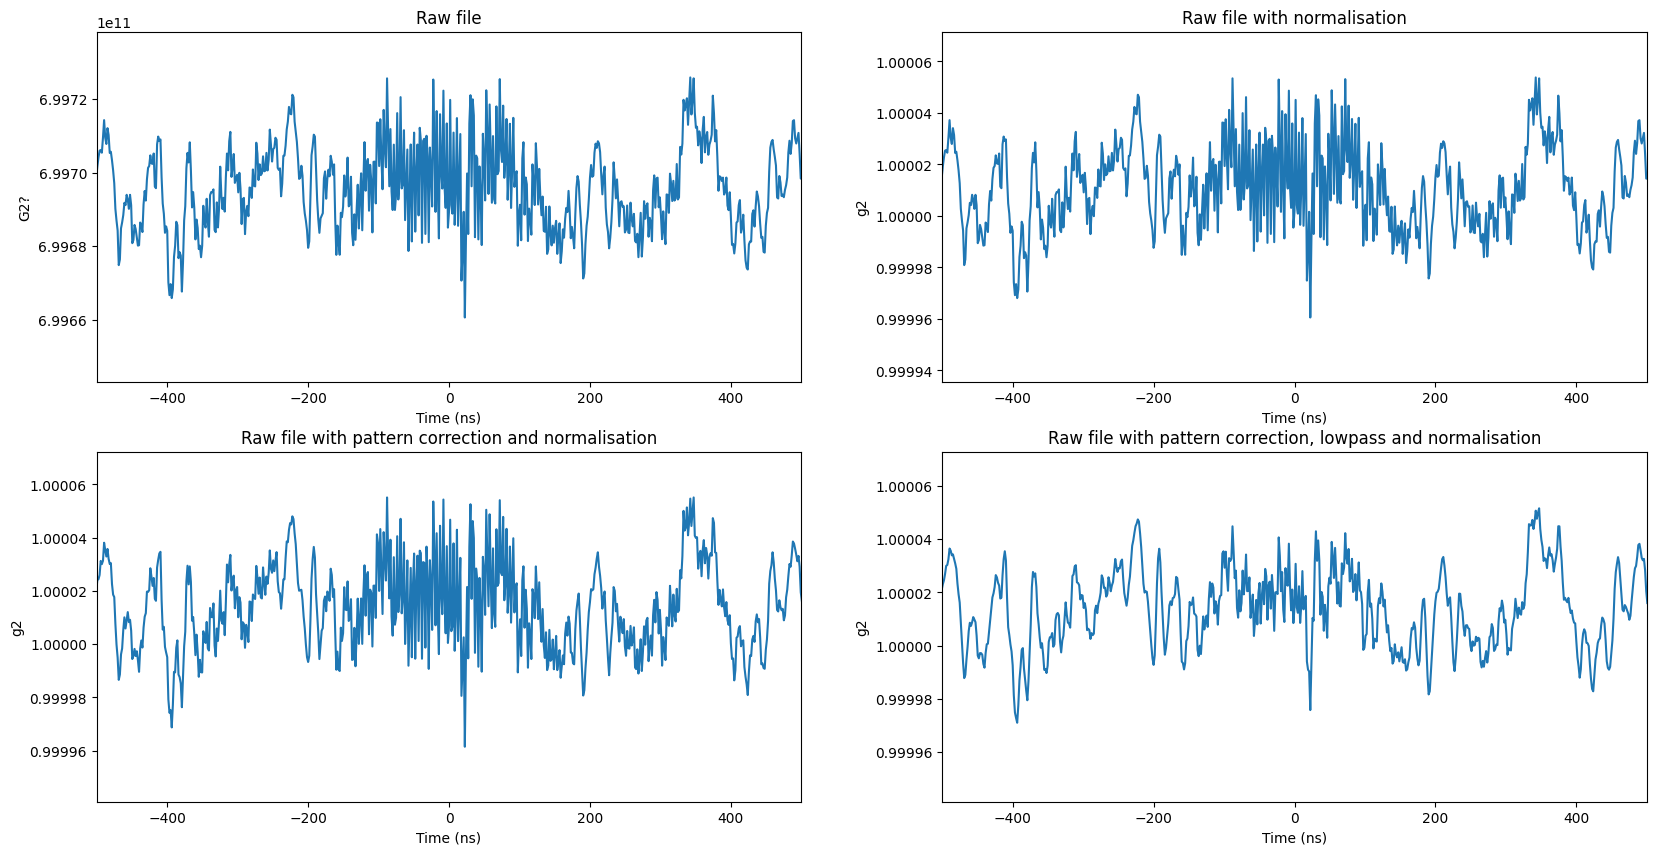

In [13]:
%matplotlib inline
meas_number = 0
path = 'corr_data\measurement_' + str(meas_number).zfill(5) + '.fcorr'
data = np.loadtxt(path)
t_width = 1.6

fig, ax = plt.subplots(ncols = 2, nrows=2, figsize=(20, 10))
ax[0,0].plot(np.arange(-5000 * t_width, 5000*t_width, t_width), data)
ax[0,0].set(xlabel='Time (ns)', ylabel='G2?', title='Raw file', xlim=[-500,500])
ax[0,1].plot(np.arange(-5000 * t_width, 5000*t_width, t_width), data/np.mean(data))
ax[0,1].set(xlabel='Time (ns)', ylabel='g2', title='Raw file with normalisation', xlim=[-500,500])
ax[0,1].ticklabel_format(useOffset=False)

# Apply pattern correction
ax[1,0].plot(np.arange(-5000 * t_width, 5000*t_width, t_width), pattern_correction(data))
ax[1,0].set(xlabel='Time (ns)', ylabel='g2', title='Raw file with pattern correction and normalisation', xlim=[-500,500])
ax[1,0].ticklabel_format(useOffset=False)
#And lowpass
ax[1,1].plot(np.arange(-5000 * t_width, 5000*t_width, t_width), lowpass(pattern_correction(data)))
ax[1,1].set(xlabel='Time (ns)', ylabel='g2', title='Raw file with pattern correction, lowpass and normalisation', xlim=[-500,500])
ax[1,1].ticklabel_format(useOffset=False)

## Fourier transform

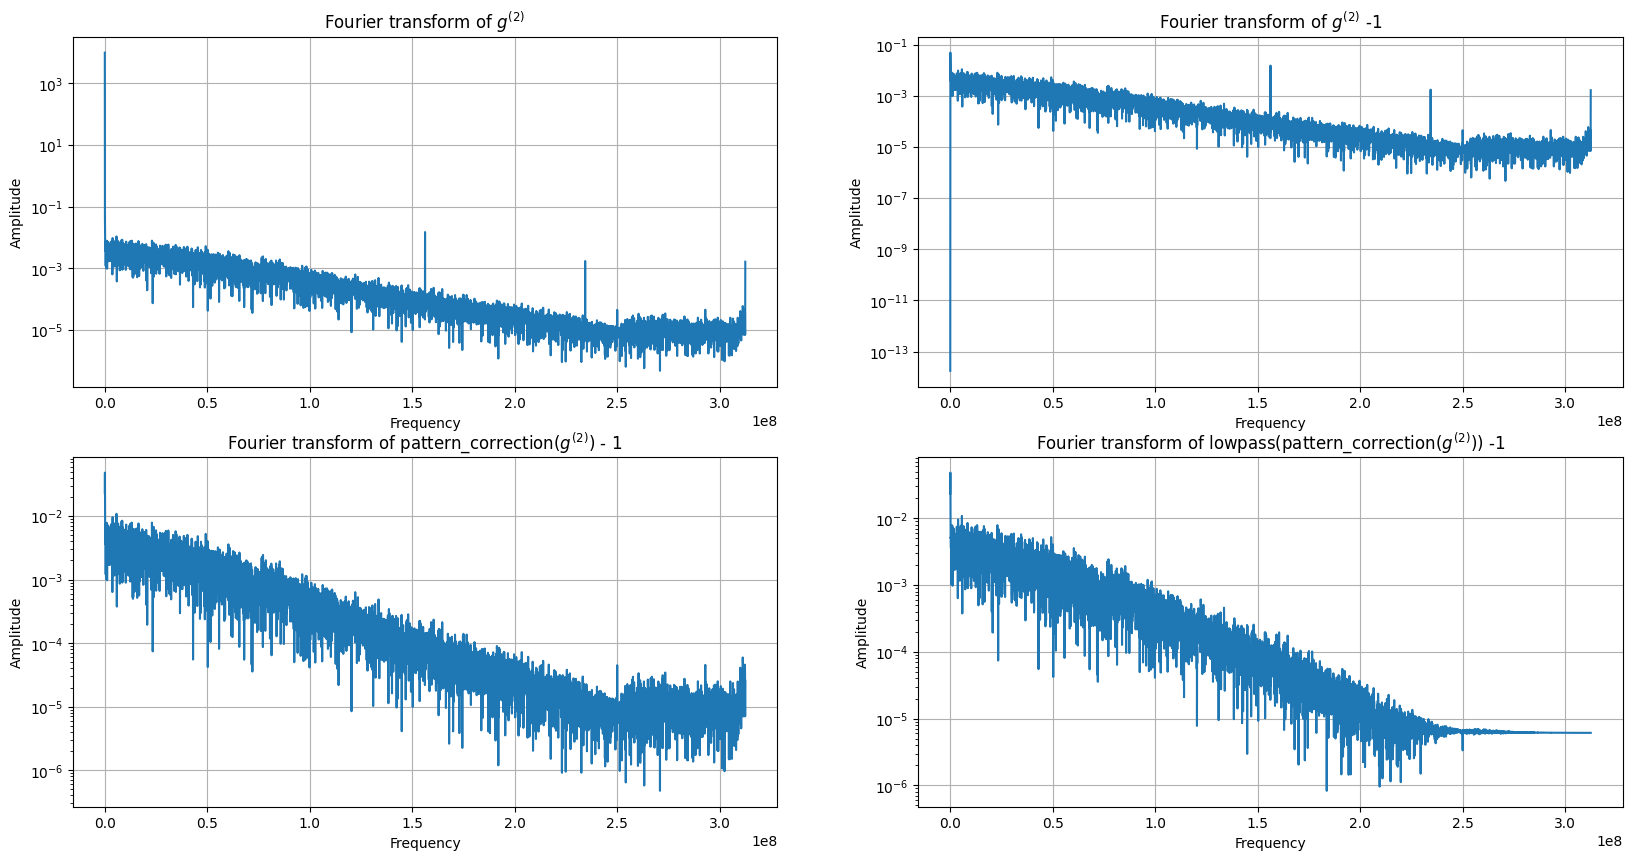

In [14]:
%matplotlib inline
meas_number = 20
path = 'corr_data\measurement_' + str(meas_number).zfill(5) + '.fcorr'


fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20, 10))
data = np.loadtxt(path)
data = data/np.mean(data) 
fourier = np.fft.rfft(data)
frequencies = np.fft.rfftfreq(len(data), t_width*1e-9)
ax[0,0].plot(frequencies, np.abs(fourier)) # Absolute or real value?
ax[0,0].set(xlabel='Frequency', ylabel='Amplitude', yscale='log', title='Fourier transform of $g^{(2)}$');
ax[0,0].grid()

data = np.loadtxt(path)
data = data/ np.mean(data) -1
fourier = np.fft.rfft(data)
frequencies = np.fft.rfftfreq(len(data), t_width*1e-9)
ax[0,1].plot(frequencies, np.abs(fourier)) # Absolute or real value?
ax[0,1].set(xlabel='Frequency', ylabel='Amplitude', yscale='log', title='Fourier transform of $g^{(2)}$ -1');
ax[0,1].grid()

data = np.loadtxt(path)
data = pattern_correction(data) - 1
fourier = np.fft.rfft(data)
frequencies = np.fft.rfftfreq(len(data), t_width*1e-9)
ax[1,0].plot(frequencies, np.abs(fourier)) # Absolute or real value?
ax[1,0].set(xlabel='Frequency', ylabel='Amplitude', yscale='log', title='Fourier transform of pattern_correction($g^{(2)}$) - 1');
ax[1,0].grid()

data = np.loadtxt(path)
data = lowpass(pattern_correction(data)) - 1
fourier = np.fft.rfft(data)
frequencies = np.fft.rfftfreq(len(data), t_width*1e-9)
ax[1,1].plot(frequencies, np.abs(fourier)) # Absolute or real value?
ax[1,1].set(xlabel='Frequency', ylabel='Amplitude', yscale='log', title='Fourier transform of lowpass(pattern_correction($g^{(2)}$)) -1');
ax[1,1].grid()

## How to average?

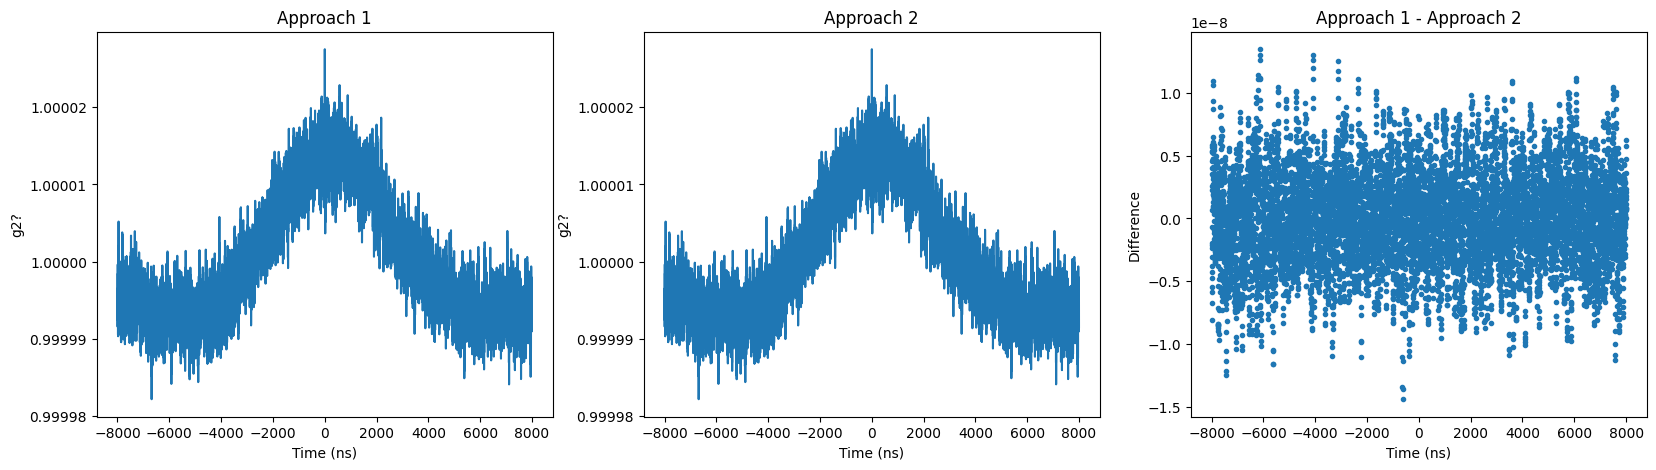

In [15]:
%matplotlib inline
# 1st approach: Add all correlation data, then Nomralise
sum = np.zeros(10000)
for n in range(41): 
    path = 'corr_data\measurement_' + str(n).zfill(5) + '.fcorr'
    data = np.loadtxt(path)
    sum += data
average_1 = sum/np.mean(sum)

# 2nd approach: Normalise each correlation data, then add and normalise again
sum = np.zeros(10000)
for n in range(41): 
    path = 'corr_data\measurement_' + str(n).zfill(5) + '.fcorr'
    data = np.loadtxt(path)
    sum += data/np.mean(data)
average_2 = sum/np.mean(sum)

# Plot
fig, ax = plt.subplots(ncols = 3, figsize=(20, 5))
ax[0].plot(np.arange(-5000 * t_width, 5000*t_width, t_width), average_1)
ax[0].set(xlabel='Time (ns)', ylabel='g2?', title='Approach 1')
ax[0].ticklabel_format(useOffset=False)
ax[1].plot(np.arange(-5000 * t_width, 5000*t_width, t_width), average_2)
ax[1].set(xlabel='Time (ns)', ylabel='g2?', title='Approach 2')
ax[1].ticklabel_format(useOffset=False)
ax[2].plot(np.arange(-5000 * t_width, 5000*t_width, t_width), average_1 - average_2, '.')
ax[2].set(xlabel='Time (ns)', ylabel='Difference', title='Approach 1 - Approach 2')
ax[2].ticklabel_format(useOffset=False)

## Combine pattern_correction lowpass and average over 40 measurements 
Uses weighted mean: 
\begin{equation*}
\bar{x} = \frac{\sum \frac{\vec{x}}{\sigma_{x}^2}}{\sum \sigma_{x}^{-2}}
\end{equation*}

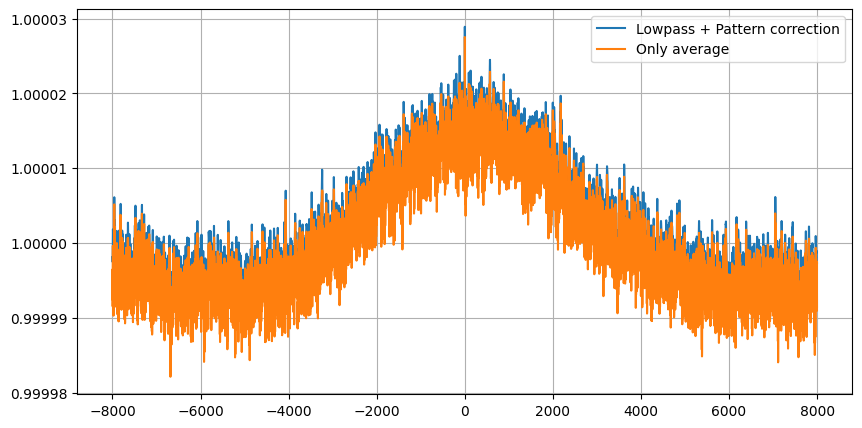

In [16]:
%matplotlib inline
sum = np.zeros(10000)
weight_sum = 0
for n in range(41): 
    path = 'corr_data\measurement_' + str(n).zfill(5) + '.fcorr'
    data = np.loadtxt(path)
    data = lowpass(pattern_correction(data))
    weight = 1
    sum += data*weight
    weight_sum += weight
average = sum/weight_sum

fig,ax = plt.subplots(figsize=(10, 5))
ax.plot(np.arange(-5000 * t_width, 5000*t_width, t_width), average, label= 'Lowpass + Pattern correction')

# Raw averaged data w/o lowpass, pattern correction
sum = np.zeros(10000)
for n in range(41): 
    path = 'corr_data\measurement_' + str(n).zfill(5) + '.fcorr'
    data = np.loadtxt(path)
    sum += data/np.mean(data)
average_2 = sum/np.mean(sum)
ax.plot(np.arange(-5000 * t_width, 5000*t_width, t_width), average_2, label= 'Only average')

ax.ticklabel_format(useOffset=False)
#ax.set(xlim=[-300,300])
ax.legend()
ax.grid()

## Try applying lowpass to individual raw data

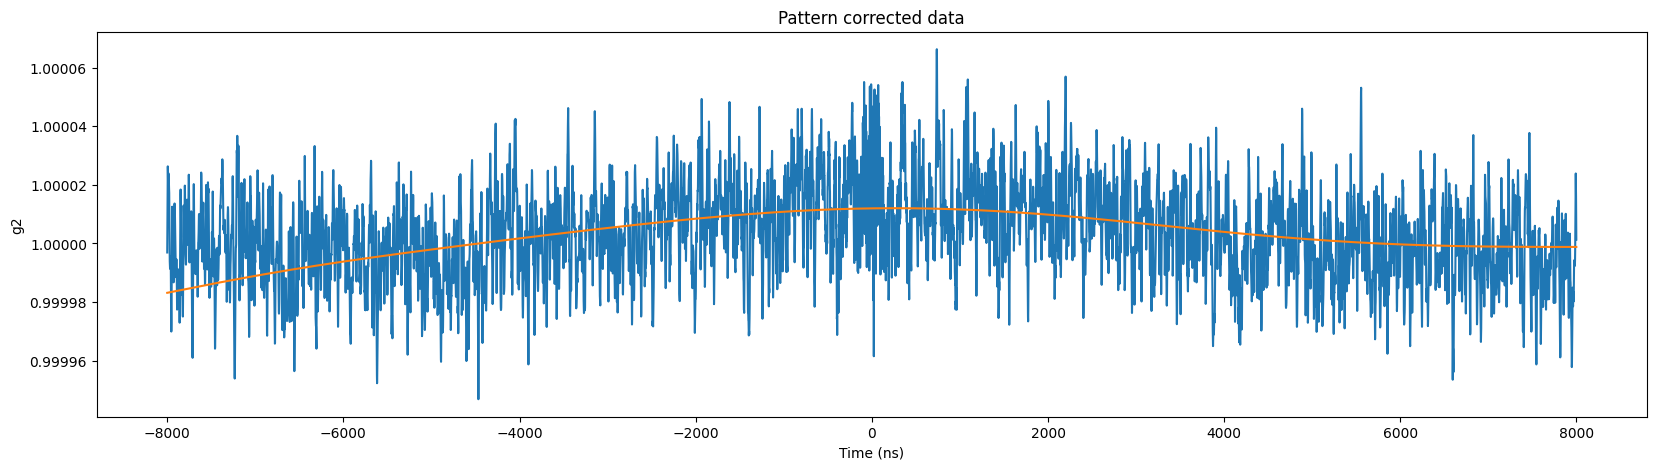

In [17]:
%matplotlib inline
meas_number = 0
path = 'corr_data\measurement_' + str(meas_number).zfill(5) + '.fcorr'
data = np.loadtxt(path)
data = pattern_correction(data)
cutoff_freq = 1e-4
lowpass_data = lowpass(data, cutoff_freq)

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(np.arange(-5000 * t_width, 5000*t_width, t_width), data)
ax.set(xlabel='Time (ns)', ylabel='g2', title='Pattern corrected data')
ax.ticklabel_format(useOffset=False)
ax.plot(np.arange(-5000 * t_width, 5000*t_width, t_width), lowpass_data)


## Lowpass before pattern correction - 29.5. --> Idea discontinued

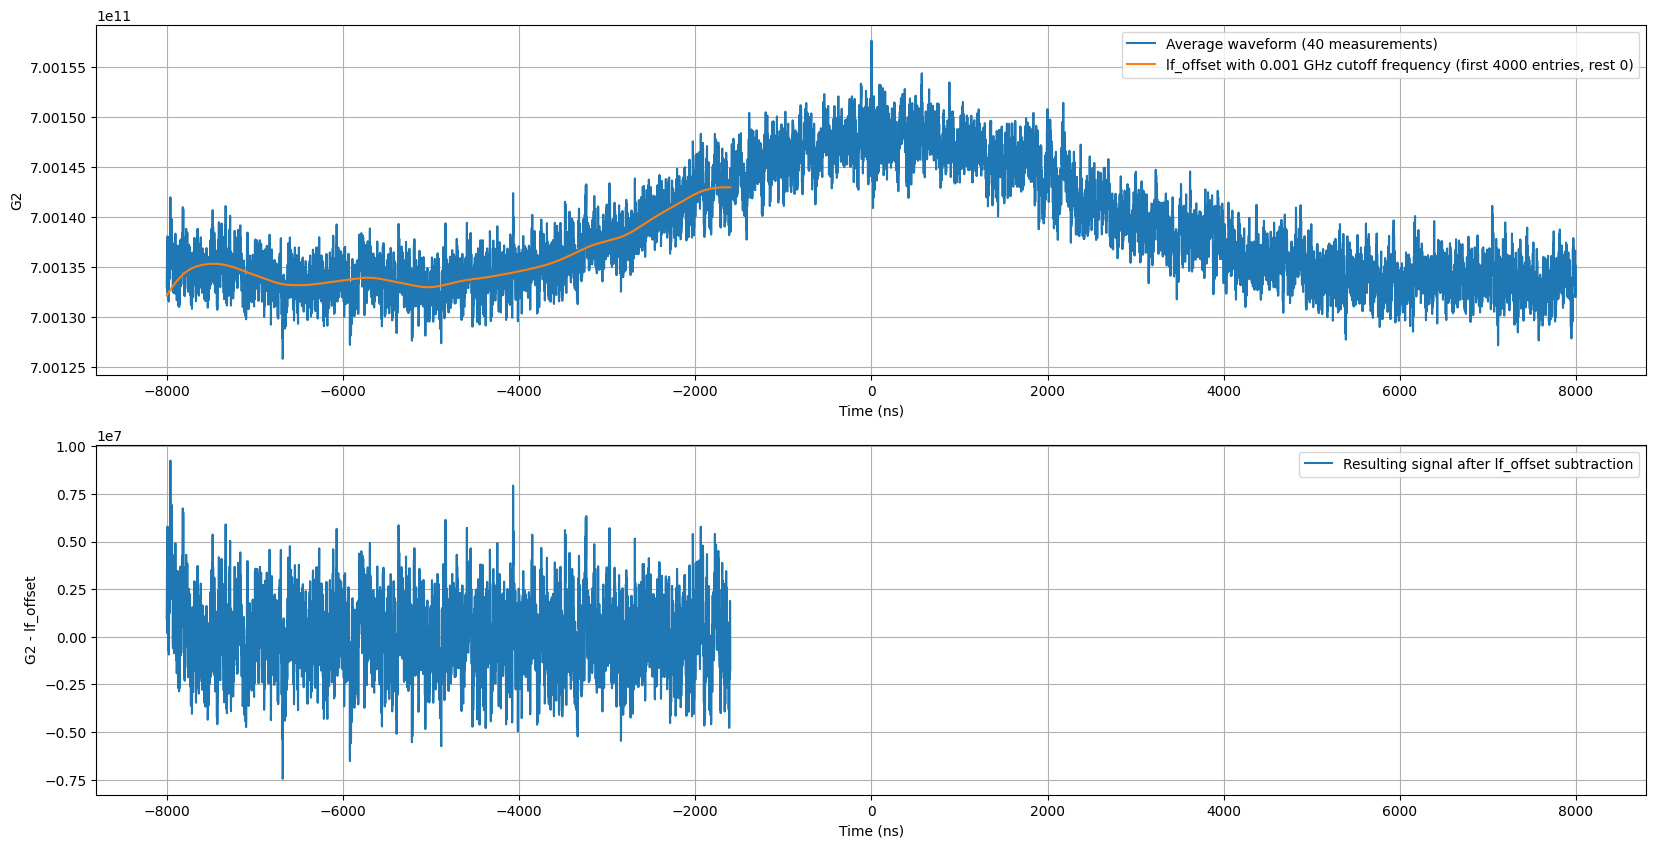

In [18]:
%matplotlib inline
# First: Average over all measurements to get "stable" lf-peak
sum = np.zeros(10000)
for n in range(41): 
    path = 'corr_data\measurement_' + str(n).zfill(5) + '.fcorr'
    data = np.loadtxt(path)
    sum += data
mean_waveform_with_offset = sum/41
# Apply lowpass to the first 4000 bins
cutoff_freq = 1e-3 #GHz
lf_offset = lowpass(mean_waveform_with_offset[:4000], cutoff_freq)
# Append 0 for it beeing the same length as raw data files for subtraction:
lf_offset = np.append(lf_offset, np.zeros_like(mean_waveform_with_offset[4000:]))


# Plot for visualisation
t = np.arange(-5000 * t_width, 5000*t_width, t_width)             
pattern_data = mean_waveform_with_offset - lf_offset
plt.close('all')
fig, ax = plt.subplots(nrows = 2, figsize=(20, 10))
ax[0].plot(t, mean_waveform_with_offset, label='Average waveform (40 measurements)')
ax[0].plot(t[:4000], lf_offset[:4000], label='lf_offset with {} GHz cutoff frequency (first 4000 entries, rest 0)'.format(cutoff_freq))
ax[0].set(xlabel='Time (ns)', ylabel='G2')
ax[0].ticklabel_format(useOffset=False)
ax[0].grid()
ax[0].legend()
ax[1].sharex(ax[0])
ax[1].plot(t[:4000], pattern_data[:4000], label='Resulting signal after lf_offset subtraction')
#ax[1].plot(t[:8], corr, label='Rest of the signal')
ax[1].set(xlabel='Time (ns)', ylabel='G2 - lf_offset')
ax[1].ticklabel_format(useOffset=False)
ax[1].grid()
ax[1].legend()


## All files...

In [19]:

def data_reduction(directory, number_data:int=None):
    ''' 
    Function that handles the data reduction of the correlation data. This includes the pattern correction, lowpass filter, normalisation and the weighted average.
    This function assumes the data is named 'measurement_XXXXX.fcorr' where XXXXX is the number of the data.
    Takes:
        - directory: str, the directory where the files are stored.
        - number_data: int, all files from 0 to number_data will be used. Default is None, which means all files in the directory will be used.
    Returns:
        - average_g2: np.array, the corrected weighted and nomralised average of all the data. 
    '''
    if number_data is None:
        number_data = count_files_in_directory(directory)
    sum = np.zeros(10000)
    weight_sum = 0
    for n in tqdm(range(number_data), desc='Do data reduction'): 
        path = directory + '\measurement_' + str(n).zfill(5) + '.fcorr'
        data = np.loadtxt(path)
        data = pattern_correction(data)
        weight = np.std(data)**-2
        sum += data*weight
        weight_sum += weight
    average_g2 = sum/weight_sum
    return lowpass(average_g2)

def count_files_in_directory(directory):
    ''' 
    Function that counts the number of files in a given directory. 
    '''
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])



# Legacy code: 
def get_lf_offset(directory, number_data, cutoff_freq=1e-3):
    ''' 
    Helper function that calculates the low frequency offset for the data reduction.
    Takes: 
        - directory: str, the directory where the files are stored.
        - number_data: int, all files from 0 to number_data will be used.
        - cutoff_freq: float, the cutoff frequency for the lowpass filter.
    Returns:
        - lf_offset: np.array, the low frequency offset for the data reduction. It contains the offset in the first 4000 bins and 0s for the rest.
    '''
    sum = np.zeros(10000)
    for n in tqdm(range(number_data), desc='Calculating low frequency offset'): 
        path = directory + '\short_' + str(n).zfill(5) + '.fcorr'
        data = np.loadtxt(path)
        sum += data
    mean_waveform_with_offset = sum/number_data
    # Apply lowpass to the first 4000 bins of the mean G2 function
    lf_offset = lowpass(mean_waveform_with_offset[:4000], cutoff_freq)
    # Append 0s for it beeing the same length as raw data files for subtraction later:
    lf_offset = np.append(lf_offset, np.zeros_like(mean_waveform_with_offset[4000:]))
    return lf_offset

In [20]:
measurement_name  = '20240319_cable_lengths' # This corresponds to the folder name of the measurement. Nedds only to be changed for completely differnt measurements
number_measurements=count_files_in_directory('D:\\' + measurement_name) # Number of measurements to be used for the average
suffix = 'average' +'_'+ str(number_measurements) # This is the suffix of the reduced data file. It is used to distinguish between different data reduction methods.

# Only do time intensive data reduction if not already done:
if not os.path.exists('reduced_data\\' + measurement_name + '\\' + suffix + '.txt'):  
    average = data_reduction('D:\\' + measurement_name, number_measurements)
    np.savetxt('reduced_data\\' + measurement_name + '\\' + suffix + '.txt', average)
else:
    average = np.loadtxt('reduced_data\\' + measurement_name + '\\' + suffix + '.txt')

## Try fitting correlation peak template 

3.680029916636903e-08


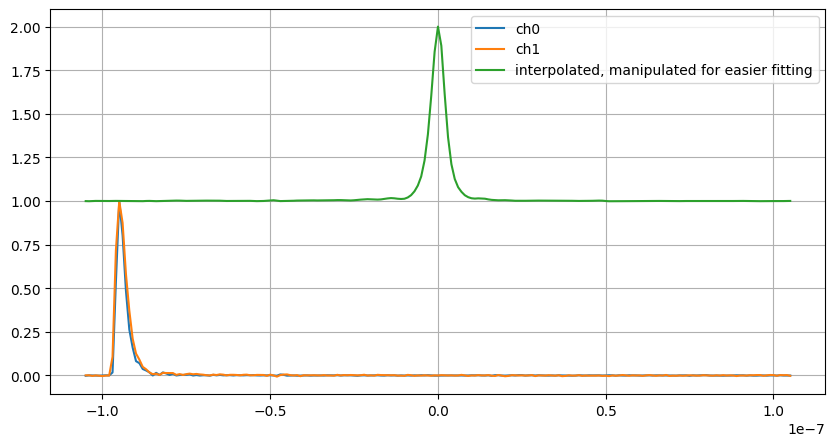

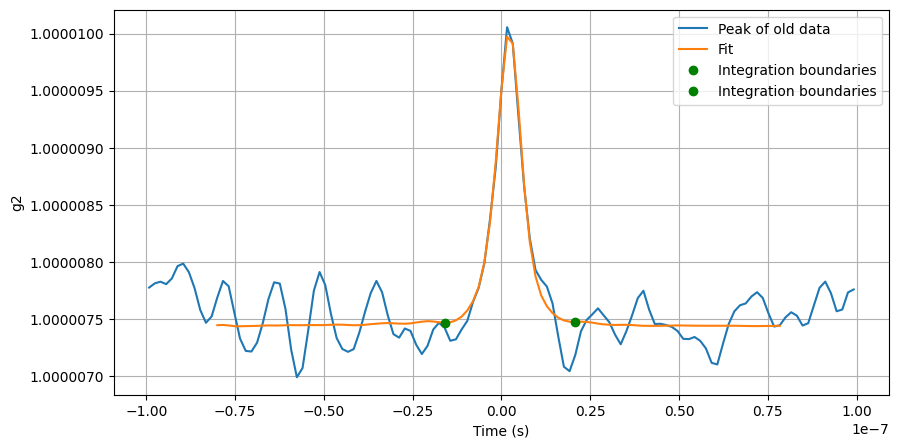

In [21]:
data = np.loadtxt('reduced_data\\20240319_cable_lengths\\average_7251.txt') # Old data from Andi
t = np.arange(-5000 * t_width, 5000*t_width, t_width)*1e-9
centre_mask = np.logical_and(t > -100e-9, t < 100e-9) # Mask for only plotting peak centre
fit_mask = np.logical_and(t > -80e-9, t < 80e-9) # Mask for fitting the peak

# Load the shape of the single photon pulses from calib files
shape0 =  np.loadtxt('D:\\20240319_cable_lengths\\calibs_ch0\\calib.shape1')
shape1 = np.loadtxt('D:\\20240319_cable_lengths\\calibs_ch1\\calib.shape1')
# Correlation and normalisation/shifting for easier fitting
pulse = scipy.signal.correlate(shape0[:,1], shape1[:,1], mode='same')
pulse= pulse/np.max(pulse) +1
x = np.arange(0,211)*1e-9
x = x - x[np.argmax(pulse)]

# Interpolation, and fitting
y = scipy.interpolate.interp1d(x, pulse, fill_value='extrapolate', kind='linear')
def fit_func(x, a, b, c, d):
    return a*y(b*x - c) +d
p0 = [3e-6, 1, 0, 10]
popt, pcov = scipy.optimize.curve_fit(fit_func, t[fit_mask], data[fit_mask], p0=p0)

# Find the local minima next to the peak as integration boundaries
local_minima = scipy.signal.argrelmin(fit_func(t[fit_mask], *popt))[0]
minima_threshold = 0.25e-7
# only keep minima that are close to the peak, adjust threshold if necessary
local_minima = [m for m in local_minima if np.abs(t[fit_mask][m]) < minima_threshold]

# Do the integration
lower_bound = t[fit_mask][local_minima[0]]
upper_bound = t[fit_mask][local_minima[1]]
integral, error_estimate = scipy.integrate.quad(fit_func, lower_bound, upper_bound, args=tuple(popt))
print(integral)

# Plotting
plt.close('all')
fig,ax = plt.subplots(figsize=(10, 5))
ax.plot(x, shape0[:,1], label='ch0')
ax.plot(x, shape1[:,1], label='ch1')
ax.plot(x, y(x), label='interpolated, manipulated for easier fitting')
ax.grid()
ax.legend()
fig,ax = plt.subplots(figsize=(10, 5))
ax.plot(t[centre_mask], data[centre_mask], label='Peak of old data')
ax.plot(t[fit_mask], fit_func(t[fit_mask], *popt), label='Fit')
for i in local_minima:
    ax.plot(t[fit_mask][i], fit_func(t[fit_mask][i], *popt), 'go', label='Integration boundaries')
ax.set(xlabel='Time (s)', ylabel='g2')
ax.ticklabel_format(useOffset=False)
ax.grid() 
ax.legend()

This in principle seems good. However often times peak not symm. whichl leads to integration bounds beeing all over the place. Furthermore integration bounds should be 
1) either close to the peak so the integration of the long constant 1-tail is omitted 
2) or the peaks should be shifted downn for integration so the tail is at 0
3) alternativley one could integrate the oeak as is and subtract the offset by doing a linear approximation of the baseline (fit?) and subtracting this area in the integration bounds --> maybe cleaner

## New test data from 5.6. - See if 78MHZ artifact is still present 

In [22]:
measurement_name = '20240605_10x10test'
num = 2531

filename = 'average' + str(num) # This is the filename of the reduced data file. can be used to distinguish between different data reduction methods.
# Only do time intensive data reduction if not already done:
if not os.path.exists('reduced_data\\' + measurement_name + '\\' + filename + '.txt'):  
    average = data_reduction('D:\\' + measurement_name, num)
    if not os.path.exists('reduced_data\\' + measurement_name):
        os.makedirs('reduced_data\\' + measurement_name)
    np.savetxt('reduced_data\\' + measurement_name + '\\' + filename + '.txt', average)
else:
    average = np.loadtxt('reduced_data\\' + measurement_name + '\\' + filename + '.txt')

[Text(0.5, 0, 'Frequency (MHz)'), Text(0, 0.5, 'Amplitude'), None]

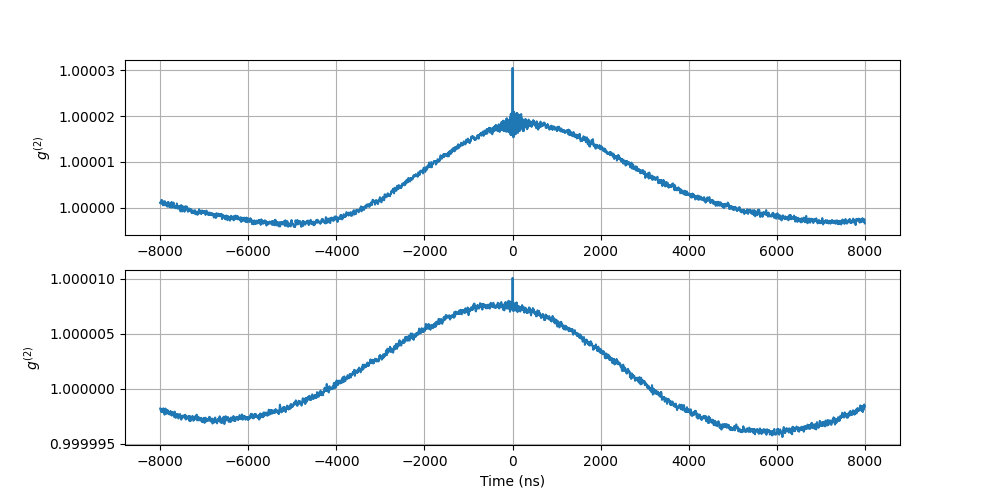

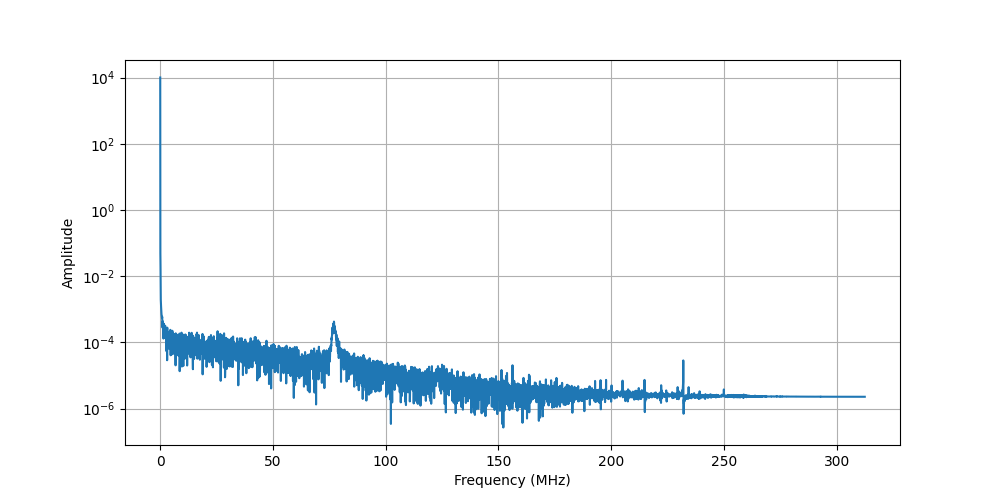

In [23]:
plt.close('all')
%matplotlib widget
t_width = 1.6
t = np.arange(-5000 * t_width, 5000*t_width, t_width)  
old_data_average = np.loadtxt('reduced_data\\20240319_cable_lengths\\average_7251.txt')
fig,ax = plt.subplots(nrows =2, figsize=(10, 5))
ax[0].plot(t, average)
ax[0].ticklabel_format(useOffset=False)
ax[0].set(ylabel='$g^{(2)}$')
ax[1].set(xlabel='Time (ns)', ylabel='$g^{(2)}$')
ax[1].plot(t, old_data_average)
ax[0].sharex(ax[1])
ax[1].ticklabel_format(useOffset=False)
ax[0].grid()
ax[1].grid()
fourier = np.fft.rfft(average)
frequencies = np.fft.rfftfreq(len(average), t_width*1e-9)
fig,ax = plt.subplots(figsize=(10, 5))
ax.plot(frequencies*1e-6, np.abs(fourier))
ax.grid()
ax.set(xlabel='Frequency (MHz)', ylabel='Amplitude', yscale='log')

[Text(0.5, 0, 'Frequency (MHz)'), Text(0, 0.5, 'Amplitude'), None]

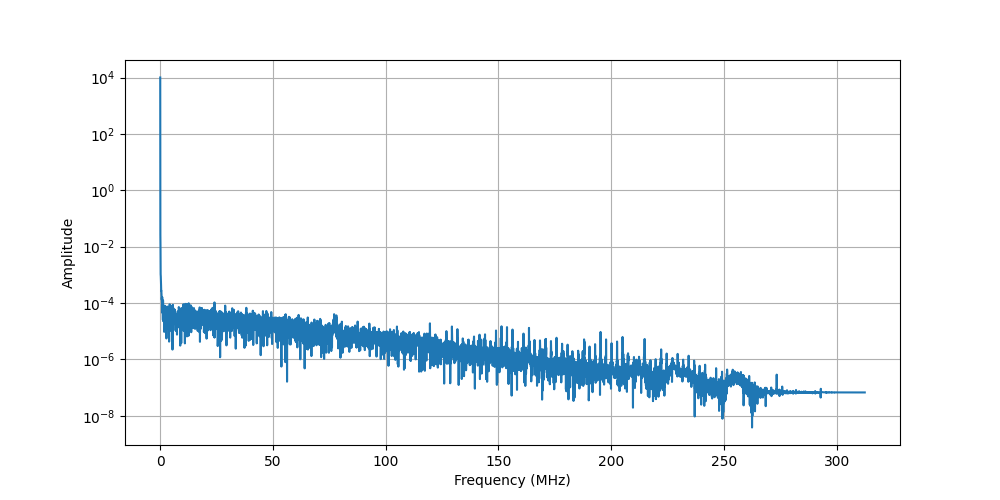

No such comm: 8e9114c973cc4d1595adc2cc4c487108
No such comm: b046cb456f00470da0d02e49a21ca382


In [24]:
fourier = np.fft.rfft(old_data_average)
frequencies = np.fft.rfftfreq(len(old_data_average), t_width*1e-9)
plt.close('all')
fig,ax = plt.subplots(figsize=(10, 5))
ax.plot(frequencies*1e-6, np.abs(fourier))
ax.grid()
ax.set(xlabel='Frequency (MHz)', ylabel='Amplitude', yscale='log')

## With long thorlabs tube vs. w/o

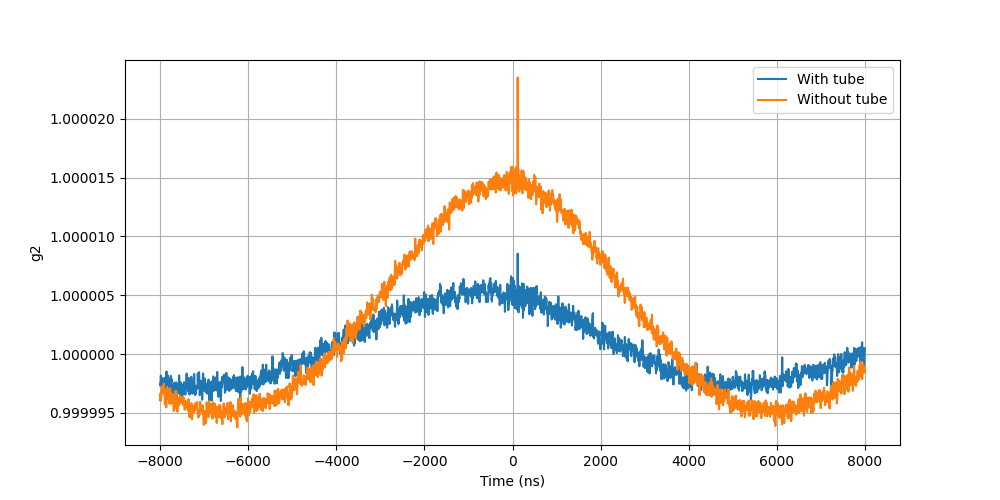

In [26]:
from helper import Data_reduction
Tube = Data_reduction('D:/20240614_10x40', 'reduced_data/20240614_10x40')
Tube.data_reduction()
NoTube = Data_reduction('D:/20240614_10x40_wotube', 'reduced_data/20240614_10x40_wotube')
NoTube.data_reduction()
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(Tube.time_arr*1e9, Tube.av_g2, label='With tube')
ax.plot(NoTube.time_arr*1e9, NoTube.av_g2, label='Without tube')
#ax.plot(NewTube.time_arr*1e9, NewTube.av_g2, label='New tube (also w/o)')
ax.set(xlabel='Time (ns)', ylabel='g2')
ax.legend()
ax.ticklabel_format(useOffset=False)
ax.grid()

 Why is w/o tube larger? Seems like a normalisation issue as bunching peak is also larger

## Timeit checks

In [27]:
import timeit

def time_data_loading():
    ''' 
    Function that tests the data loading time. 
    '''
    start = timeit.default_timer()
    for n in tqdm(range(4500)):
        path = 'D:/20240617_10x40/measurement_' + str(n).zfill(5) + '.fcorr'
        data = np.loadtxt(path)
    stop = timeit.default_timer()
    t_load = (stop - start) / 4500
    print('Time for loading all data: ', t_load)

def time_pattern_correction():
    ''' 
    Function that tests the pattern correction function. 
    '''
    start = timeit.default_timer()
    for n in tqdm(range(4500)):
        path = 'D:/20240617_10x40/measurement_' + str(n).zfill(5) + '.fcorr'
        data = np.loadtxt(path)
        data = pattern_correction(data)
    stop = timeit.default_timer()
    t_pc = (stop - start) / 4500
    print('Time for loading + pattern correction: ', t_pc)
    
def time_data_reduction():
    ''' 
    Function that tests the data reduction function. 
    '''
    start = timeit.default_timer()
    data_reduction('D:/20240617_10x40', 4500)
    stop = timeit.default_timer()
    t_all = (stop - start) / 4500
    print('Time for whole reduction: ', t_all)
    
import helper

def time_external_data_reduction():
    ''' 
    Function that tests the external data reduction function. 
    '''
    start = timeit.default_timer()
    data = helper.Data_reduction('D:/20240617_10x40/measurement', 'reduced_data/20240617_10x40', 4500)
    data.get_average_g2(True)
    stop = timeit.default_timer()
    t_ext = (stop - start) / 4500
    print('Time for whole reduction: ', t_ext)

In [28]:
# time_data_loading()
# time_pattern_correction()
# time_data_reduction()
# time_external_data_reduction()

1) Loading data at around 250 it/s
2) all 3 other steps appr. equally fast at max. 110 it/s

HOWEVER: sometimes still 30 or even less it/s
- Is part of the data already saved in memory after the first iteration whisch makes subsequent iterations faster?
- If so, can anything in the pipeline be parallelized? Speeds of down to ~10 it/s are bad for large amounts of data

## Finding a better way to integrate (hopefully)

In [29]:
NewTube = Data_reduction('D:/20240617_10x40', 'reduced_data/20240617_10x40')
NewTube.data_reduction()

Integral without offset subtraction: 3.000051506654935e-08
Integral with offset subtraction: 7.510957265264219e-14


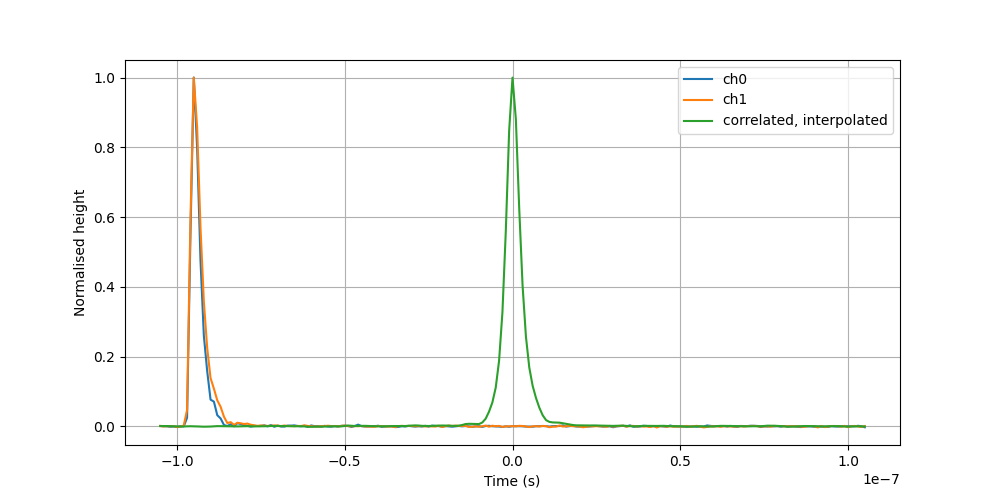

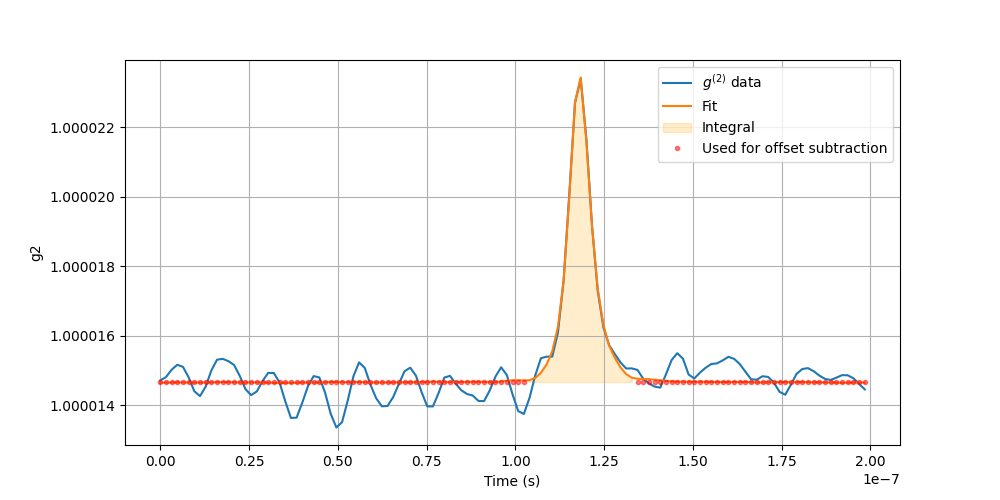

In [30]:
fit_mask = np.logical_and(NewTube.time_arr > 0, NewTube.time_arr < 200e-9) # Mask cutting the bunching peak out of the whole dataset
t = NewTube.time_arr[fit_mask]
g2 = NewTube.av_g2[fit_mask]

# Load the shape of the single photon pulses from calib files
shape0 =  np.loadtxt('D:\\20240617_10x40\\ch0\\calib.shape1')
shape1 = np.loadtxt('D:\\20240617_10x40\\ch1\\calib.shape1')
# Correlation and normalisation/shifting for easier fitting
pulse = scipy.signal.correlate(shape1[:,1], shape0[:,1], mode='same')
pulse= pulse/np.max(pulse) 
x = np.arange(0,211)*1e-9
x = x - x[np.argmax(pulse)]

# Interpolation, and fitting
y = scipy.interpolate.interp1d(x, pulse, fill_value='extrapolate', kind='linear')
def fit_func(x, a, b, c, d):
    return a*y(b*x - c) +d
p0 = [22e-6, 1, 120e-9,1]
popt, pcov = scipy.optimize.curve_fit(fit_func, t, g2, p0=p0)

# Determine the integration bounds
peak_pos = NewTube.time_arr[np.argmax(NewTube.av_g2)] 
width = 15e-9 # width for the integration
int_bounds = np.array([peak_pos - width, peak_pos + width])

# Calculate offset
peak_mask = (t > peak_pos - width) & (t < peak_pos + width) # All g2 entries inside the peak 
offset = np.mean(fit_func(t, *popt)[np.logical_not(peak_mask)])

# Do the integration
integral, error_estimate = scipy.integrate.quad(fit_func, *int_bounds, args=tuple(popt))
print('Integral without offset subtraction:', integral)
print('Integral with offset subtraction:', integral - offset*(int_bounds[1] - int_bounds[0]))

# Plotting
fig,ax = plt.subplots(figsize=(10, 5))
ax.plot(x, shape0[:,1], label='ch0')
ax.plot(x, shape1[:,1], label='ch1')
ax.plot(x, y(x), label='correlated, interpolated')
ax.set(xlabel='Time (s)', ylabel='Normalised height')
ax.grid()
ax.legend()

fig,ax = plt.subplots(figsize=(10, 5))
ax.plot(t, g2, label='$g^{(2)}$ data')
ax.plot(t, fit_func(t, *popt), label='Fit')
ax.fill_between(t, fit_func(t, *popt), offset, where=peak_mask, color='orange', alpha=0.2, label='Integral')
ax.plot(t[np.logical_not(peak_mask)], np.ones_like(t[np.logical_not(peak_mask)])*offset, 'r.', label='Used for offset subtraction', alpha=0.5)
ax.set(xlabel='Time (s)', ylabel='g2')
ax.ticklabel_format(useOffset=False)
ax.grid() 
ax.legend()

Summary:
- Use mean pulseshapes of different channels from calib data
- Correlate, interpolate and fit to $g^{(2)}$
- For integration set boundaries at $\in [max(g^{(2)})-\delta, \, max(g^{(2)})+ \delta] $, with $\delta$ beeing a free parameter
- As integral is dominated by large offset -> subtract it
- For this find mean $g^{(2)}$ outside of the integration boundaries and subtract the integral of this offset (rectangle)

Questions:
- Do the bounds make sense? -> About 2.5% deviation between $\delta=15\,ns$ and $\delta=40\,ns$
- Does the offset subtraction make sense?

IMPORTANT:
- Found out correlation order makes a difference!!
- correlate(a,b) != correlate(b,a), but rather flips the peak vertically (problematic as peak is asymmetric)
- integral dependent on it
--> Look at what Andi has done and adjust accordingly (seems like correlate(ch1,ch0) is correct, verify)

# Tests of new integration techniques after meeting on 19.6.

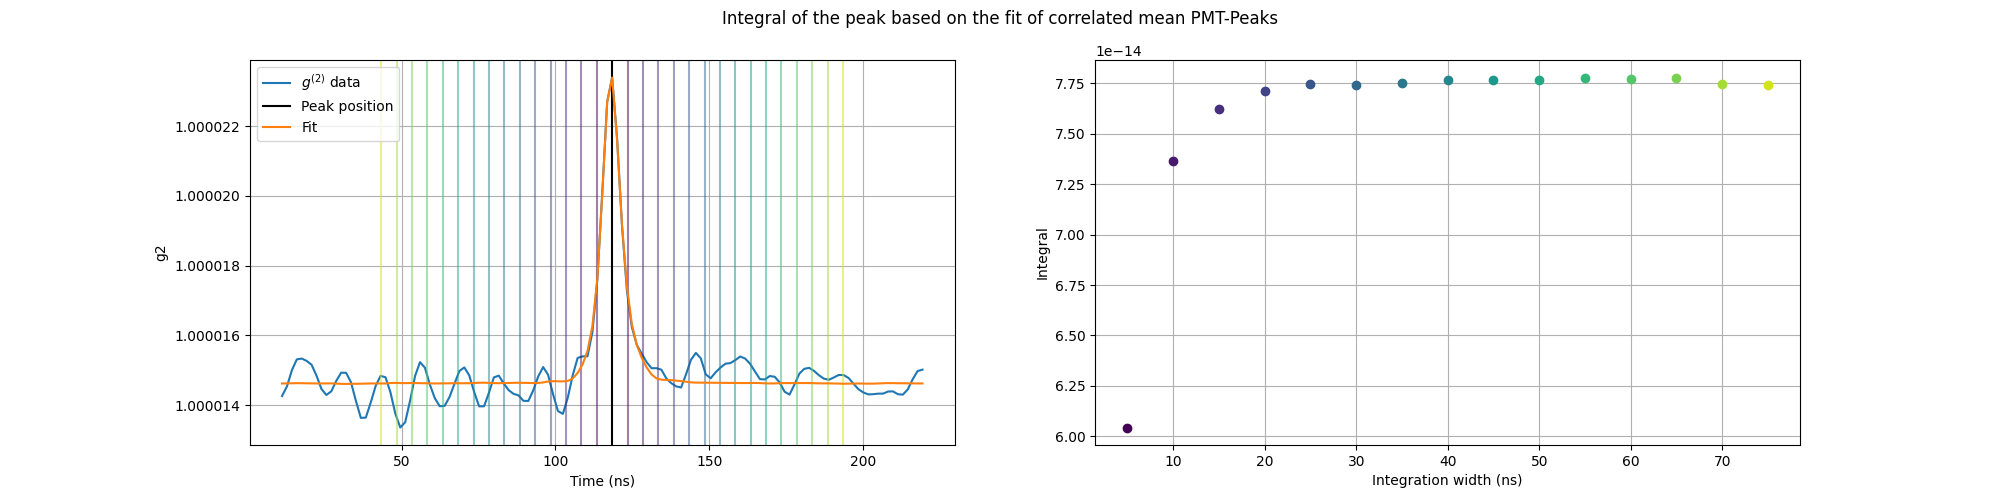

In [31]:

NewTube = Data_reduction('D:/20240617_10x40', 'reduced_data/20240617_10x40')
NewTube.data_reduction()

fit_mask = np.logical_and(NewTube.time_arr > 10e-9, NewTube.time_arr < 220e-9) # Mask cutting the bunching peak out of the whole dataset
t = NewTube.time_arr[fit_mask]
g2 = NewTube.av_g2[fit_mask]

# Load the shape of the single photon pulses from calib files
shape0 =  np.loadtxt('D:\\20240617_10x40\\ch0\\calib.shape1')
shape1 = np.loadtxt('D:\\20240617_10x40\\ch1\\calib.shape1')
# Correlation and normalisation/shifting for easier fitting
pulse = scipy.signal.correlate(shape1[:,1], shape0[:,1], mode='same')
pulse= pulse/np.max(pulse) 
x = np.arange(0,211)*1e-9
x = x - x[np.argmax(pulse)]

# Interpolation, and fitting
y = scipy.interpolate.interp1d(x, pulse, fill_value='extrapolate', kind='linear')
def fit_func(x, a, b, c, d):
    return a*y(b*x - c) +d
p0 = [22e-6, 1, 120e-9,1]
popt, pcov = scipy.optimize.curve_fit(fit_func, t, g2, p0=p0)

# Calculate offset
peak_mask = (t > peak_pos - 20e-9) & (t < peak_pos + 20e-9) # All g2 entries inside the peak 
offset = np.mean(fit_func(t, *popt)[np.logical_not(peak_mask)])

# Determine the integration bounds
peak_pos = NewTube.time_arr[np.argmax(NewTube.av_g2)] 
widths = np.arange(5, 80, 5)*1e-9

quad_integrals = []
for width in widths:
    int_bounds = np.array([peak_pos - width, peak_pos + width])
    # Do the integration to g2-Fit - offset:
    integral, error_estimate = scipy.integrate.quad(lambda x,a,b,c,d: fit_func(x,a,b,c,d) - offset, *int_bounds, args=tuple(popt))
    quad_integrals.append(integral)

# Plotting
fig,ax = plt.subplots(ncols = 2, figsize=(20, 5))
ax[0].plot(t*1e9, g2, label='$g^{(2)}$ data')
ax[0].axvline(peak_pos*1e9, color='k', label='Peak position')
cmap = matplotlib.colormaps.get('viridis')
for i, width in enumerate(widths):
    color = cmap(i/len(widths))
    ax[0].axvline((peak_pos - width)*1e9, alpha=0.5, color=color)
    ax[0].axvline((peak_pos + width)*1e9, alpha=0.5, color=color)
    ax[1].plot(widths[i]*1e9, quad_integrals[i], 'o', color=color)
ax[0].plot(t*1e9, fit_func(t, *popt), label='Fit')

ax[0].set(xlabel='Time (ns)', ylabel='g2')
ax[0].ticklabel_format(useOffset=False)
ax[0].grid() 
ax[0].legend()
ax[1].grid()
ax[1].set(xlabel='Integration width (ns)', ylabel='Integral')
fig.suptitle('Integral of the peak based on the fit of correlated mean PMT-Peaks');

## Use scipy.integrate.trapz instead..

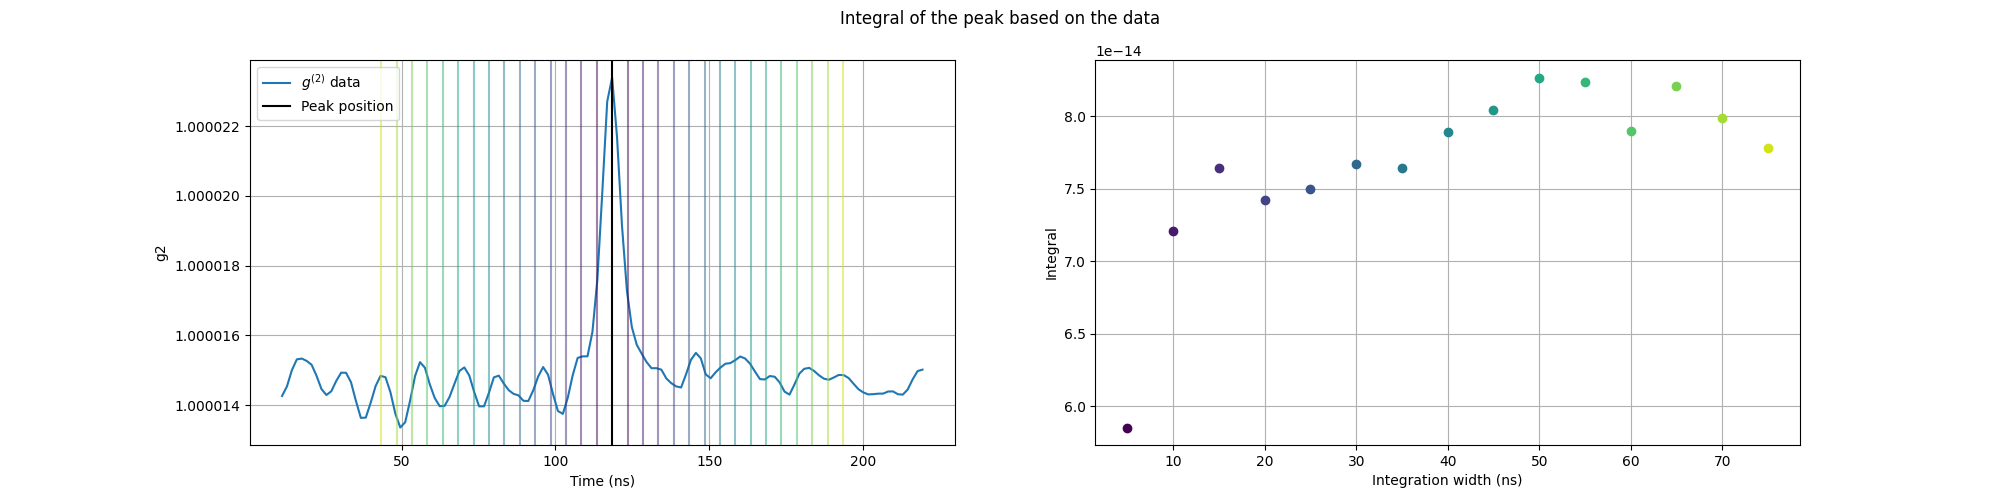

In [32]:
# Calculate the offset from the raw g2-data:
peak_mask = (t > peak_pos - 20e-9) & (t < peak_pos + 20e-9) # All g2 entries inside the peak 
offset = np.mean(g2[np.logical_not(peak_mask)])

trapz_integrals = []
for width in widths:
    int_mask = (t > peak_pos -width) & (t < peak_pos + width) # Mask with only the peak defined by peak_pos \pm width
    # Do the integration to raw g2-offset
    integral = np.trapz(g2[int_mask] - offset, dx=1.6e-9)
    trapz_integrals.append(integral)

# Plotting
fig,ax = plt.subplots(ncols = 2, figsize=(20, 5))
ax[0].plot(t*1e9, g2, label='$g^{(2)}$ data')
ax[0].axvline(peak_pos*1e9, color='k', label='Peak position')
cmap = matplotlib.colormaps.get('viridis')
for i, width in enumerate(widths):
    color = cmap(i/len(widths))
    ax[0].axvline((peak_pos - width)*1e9, alpha=0.5, color=color)
    ax[0].axvline((peak_pos + width)*1e9, alpha=0.5, color=color)
    ax[1].plot(widths[i]*1e9, trapz_integrals[i], 'o', color=color)
ax[0].set(xlabel='Time (ns)', ylabel='g2')
ax[0].ticklabel_format(useOffset=False)
ax[0].grid() 
ax[0].legend()
ax[1].grid()
ax[1].set(xlabel='Integration width (ns)', ylabel='Integral')
fig.suptitle('Integral of the peak based on the data');

## Comparison

[Text(0.5, 0, 'Integration width (ns)'), Text(0, 0.5, 'Integral')]

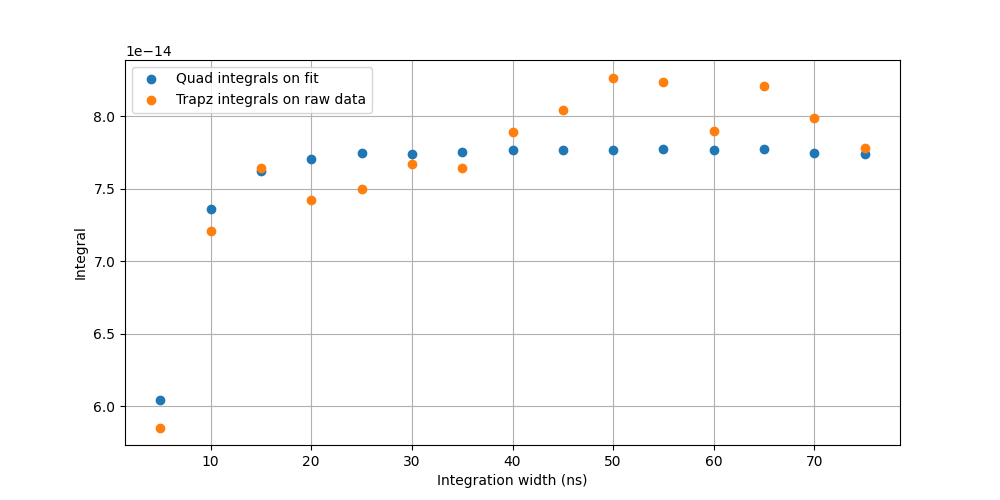

In [33]:
fig,ax = plt.subplots(figsize=(10, 5))
ax.plot(widths*1e9, quad_integrals, 'o', label = 'Quad integrals on fit')
ax.plot(widths*1e9, trapz_integrals, 'o', label = 'Trapz integrals on raw data')
ax.grid() 
ax.legend()
ax.set(xlabel='Integration width (ns)', ylabel='Integral')

## Adrians idea (?): integrate up to 95% inclusion
How does one define that? Idea:
- the integral lgets larger and larger for increase in width as long as were in the bunching peak
- at some point mainly noise and the integral is more ore less steady
- compute list of integrals for many widths and scan when 955 of maximum integral is reached

--> This would need to be done for every measurement

In [83]:
peak_pos = NewTube.time_arr[np.argmax(NewTube.av_g2)] 
widths = np.arange(1, 80, 0.01)*1e-9
# Note: In principle this integration could be optimise by a lot. The function is a linear broad-scale interpolation, therefore finding a clever way too define points where the slope changes and using trapz 
# would be much faster w/o precision loss.
integrals = [scipy.integrate.quad(lambda x,a,b,c,d: fit_func(x,a,b,c,d) - offset, peak_pos-w, peak_pos+w, args=tuple(popt))[0] for w in widths] 
integrals = np.array(integrals)
percentiles = np.percentile(integrals, 95, keepdims=True)
for index, integral in enumerate(integrals):
    # scan for the index after which integral is larger than 95% of all integrals -> 95% percentile
    if integral >= percentiles:
        width_95 = widths[index]
        break
width_95

2.4680000000000023e-08

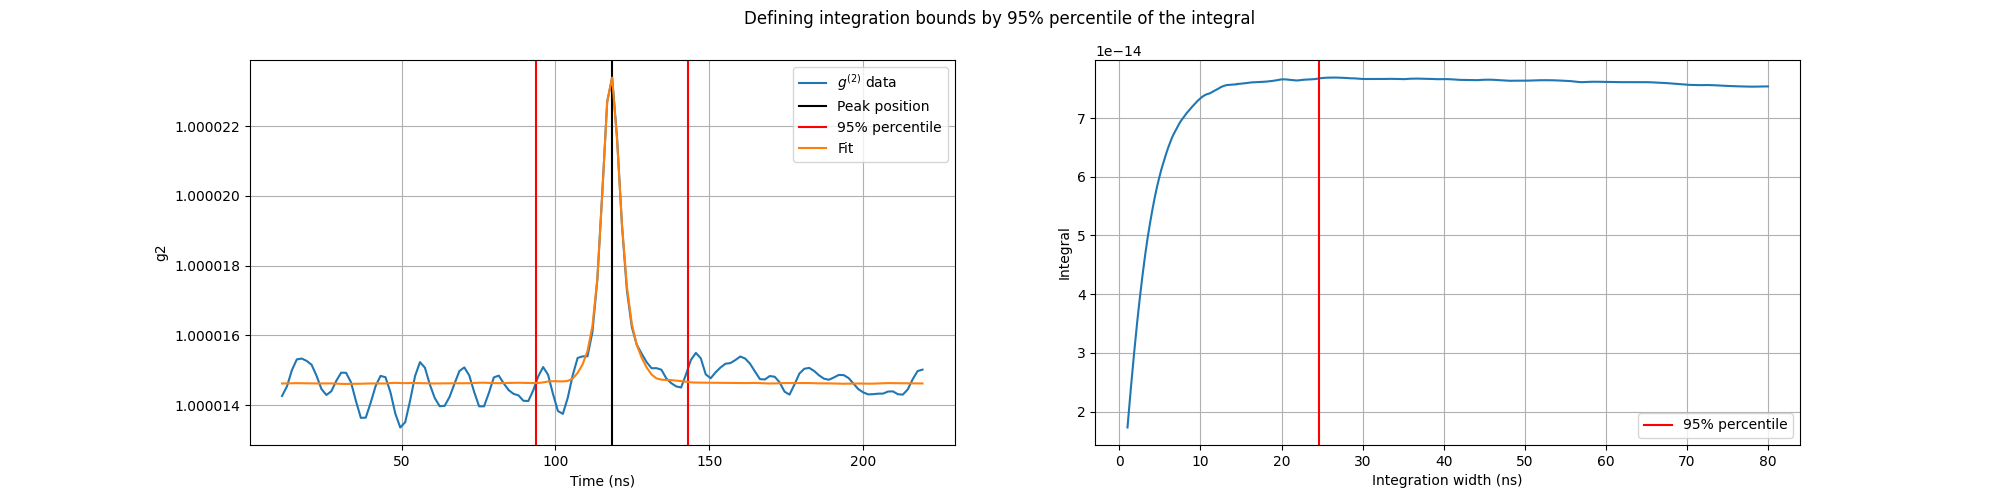

In [84]:
fig,ax = plt.subplots(ncols = 2, figsize=(20, 5))
ax[0].plot(t*1e9, g2, label='$g^{(2)}$ data')
ax[0].axvline(peak_pos*1e9, color='k', label='Peak position')
ax[0].axvline((peak_pos - width_95)*1e9, color='r', label='95% percentile')
ax[0].axvline((peak_pos + width_95)*1e9, color='r')

ax[0].plot(t*1e9, fit_func(t, *popt), label='Fit')
ax[0].set(xlabel='Time (ns)', ylabel='g2')
ax[0].ticklabel_format(useOffset=False)
ax[0].grid() 
ax[0].legend()
ax[1].plot(widths*1e9, integrals)
ax[1].axvline(width_95*1e9, color='r', label='95% percentile')
ax[1].grid()
ax[1].set(xlabel='Integration width (ns)', ylabel='Integral')
ax[1].legend()
fig.suptitle('Defining integration bounds by 95% percentile of the integral');